In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [17]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 6

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')
all_district_var_ts_LI = pd.read_pickle('data/all_district_var_ts_LI.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts_LI[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)


# Normalize the data for training

In [18]:
# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [19]:
# convert all data

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

num_features = len(train_lstm_df_dict_scaled[1].columns)


In [20]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
18


24

# LSTM Model on district 1

In [21]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/20


2023-04-06 18:00:57.325546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:58.173933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:58.398689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:58.591521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:58.829497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:59.057070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:00:59.287829: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 13s 211ms/step - loss: 0.1994
Epoch 2/20
33/33 [==============================] - 6s 188ms/step - loss: 0.1642
Epoch 3/20
33/33 [==============================] - 6s 189ms/step - loss: 0.1587
Epoch 4/20
33/33 [==============================] - 6s 193ms/step - loss: 0.1561
Epoch 5/20
33/33 [==============================] - 7s 196ms/step - loss: 0.1514
Epoch 6/20
33/33 [==============================] - 6s 196ms/step - loss: 0.1498
Epoch 7/20
33/33 [==============================] - 6s 186ms/step - loss: 0.1455
Epoch 8/20
33/33 [==============================] - 6s 184ms/step - loss: 0.1467
Epoch 9/20
33/33 [==============================] - 6s 183ms/step - loss: 0.1441
Epoch 10/20
33/33 [==============================] - 6s 186ms/step - loss: 0.1462
Epoch 11/20
33/33 [==============================] - 6s 181ms/step - loss: 0.1401
Epoch 12/20
33/33 [==============================] - 6s 193ms/step - loss: 0.1427
Epoch 13/20
33/33 [================

## Get predictions and plot

In [22]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-06 18:03:05.769624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:06.234299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:06.387502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/18 [>.............................] - ETA: 39s

2023-04-06 18:03:06.532210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 41ms/step
(18, 1)
(24, 10)


In [23]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


18/18 [==============================] - 1s 28ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 224305.95 RMSE
Test Score: 452249.19 RMSE


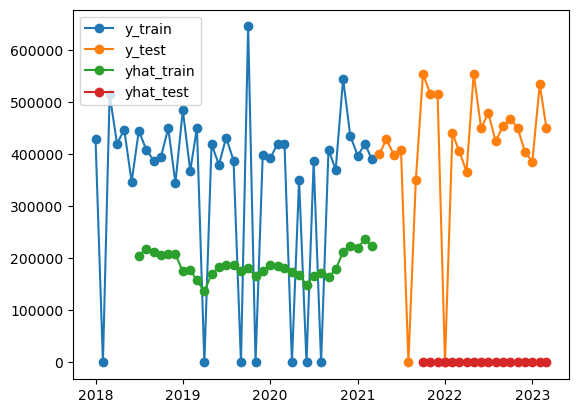

452249.18831694254

In [24]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=lookback,
)


# LSTM on all districts

district_no 1
Epoch 1/20


2023-04-06 18:03:14.819509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:15.674914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:15.937262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:16.176665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:16.481726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:16.787761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:03:17.140101: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 217ms/step - loss: 0.1915
Epoch 2/20
33/33 [==============================] - 7s 199ms/step - loss: 0.1693
Epoch 3/20
33/33 [==============================] - 7s 196ms/step - loss: 0.1652
Epoch 4/20
33/33 [==============================] - 7s 208ms/step - loss: 0.1530
Epoch 5/20
33/33 [==============================] - 7s 222ms/step - loss: 0.1501
Epoch 6/20
33/33 [==============================] - 7s 204ms/step - loss: 0.1525
Epoch 7/20
33/33 [==============================] - 8s 226ms/step - loss: 0.1473
Epoch 8/20
33/33 [==============================] - 7s 213ms/step - loss: 0.1601
Epoch 9/20
33/33 [==============================] - 7s 205ms/step - loss: 0.1500
Epoch 10/20
33/33 [==============================] - 7s 213ms/step - loss: 0.1455
Epoch 11/20
33/33 [==============================] - 7s 203ms/step - loss: 0.1413
Epoch 12/20
33/33 [==============================] - 7s 202ms/step - loss: 0.1395
Epoch 13/20
33/33 [================

2023-04-06 18:05:35.889792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:36.364349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:36.535661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:14

2023-04-06 18:05:36.698819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 29ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 194541.33 RMSE
Test Score: 452249.19 RMSE


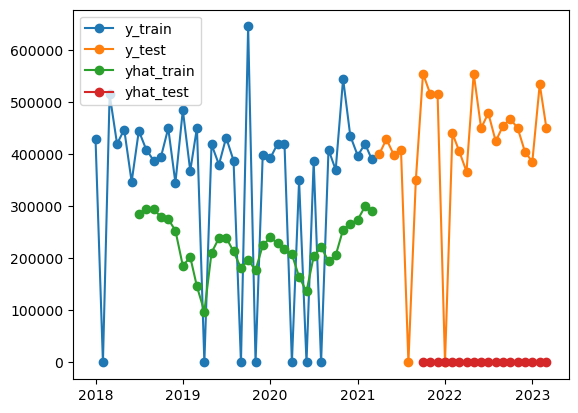

district_no 2
Epoch 1/20


2023-04-06 18:05:44.496683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:45.341953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:45.570084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:45.800762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:46.095470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:46.366130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:05:46.646091: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 111ms/step - loss: 0.2039
Epoch 2/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1568
Epoch 3/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1559
Epoch 4/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1552
Epoch 5/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1569
Epoch 6/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1584
Epoch 7/20
33/33 [==============================] - 3s 81ms/step - loss: 0.1574
Epoch 8/20
33/33 [==============================] - 3s 94ms/step - loss: 0.1530
Epoch 9/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1532
Epoch 10/20
33/33 [==============================] - 3s 72ms/step - loss: 0.1542
Epoch 11/20
33/33 [==============================] - 3s 71ms/step - loss: 0.1521
Epoch 12/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1550
Epoch 13/20
33/33 [===========================

2023-04-06 18:06:42.916392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:43.394712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:43.533706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/33 [=>............................] - ETA: 0s  

2023-04-06 18:06:43.675101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 330557.40 RMSE
Test Score: 942151.45 RMSE


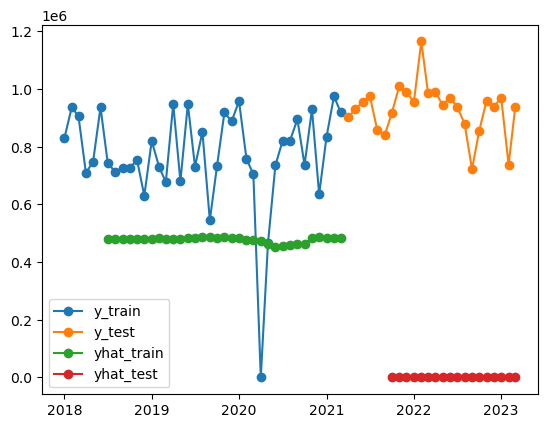

district_no 3
Epoch 1/20


2023-04-06 18:06:50.662242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:51.516582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:51.738205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:51.962485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:52.240005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:52.502500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:06:52.779896: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 8s 52ms/step - loss: 0.1126
Epoch 2/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0948
Epoch 3/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0937
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0925
Epoch 5/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0936
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0948
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0950
Epoch 8/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0941
Epoch 9/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0932
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0960
Epoch 11/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0940
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0922
Epoch 13/20
33/33 [=============================

2023-04-06 18:07:21.161082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:21.637130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:21.763330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:12

2023-04-06 18:07:21.912702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 66429.61 RMSE
Test Score: 187180.72 RMSE


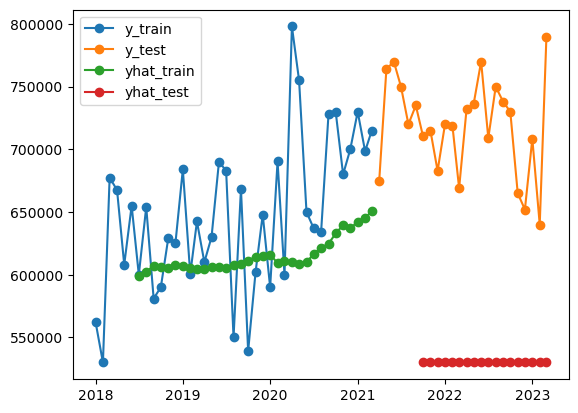

district_no 4
Epoch 1/20


2023-04-06 18:07:29.375214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:30.219397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:30.471933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:30.705011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:31.020672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:31.288927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:07:31.589695: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 9s 55ms/step - loss: 0.0923
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0797
Epoch 3/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0802
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0793
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0804
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0818
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0800
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0788
Epoch 9/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0817
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0793
Epoch 11/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0786
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0798
Epoch 13/20
33/33 [=============================

2023-04-06 18:08:00.547172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:01.055331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:01.221012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:17

2023-04-06 18:08:01.408500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 81507.30 RMSE
Test Score: 270948.23 RMSE


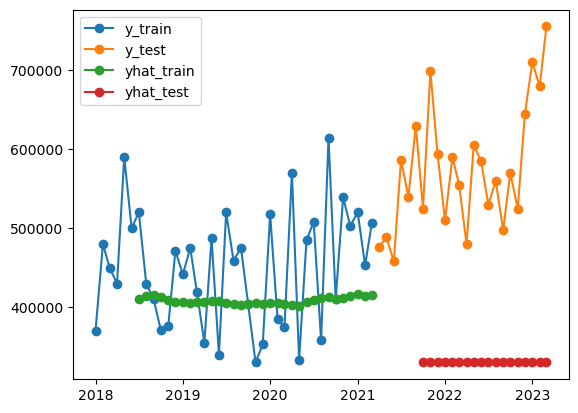

district_no 5
Epoch 1/20


2023-04-06 18:08:08.653703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:09.518420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:09.744963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:09.986973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:10.315058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:10.582064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:10.904527: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 8s 58ms/step - loss: 0.1183
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0985
Epoch 3/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0973
Epoch 4/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0979
Epoch 5/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0969
Epoch 6/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0965
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0979
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0964
Epoch 9/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0942
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0959
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0946
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0930
Epoch 13/20
33/33 [=============================

2023-04-06 18:08:41.140536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:41.644084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:41.810142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:54

2023-04-06 18:08:41.964940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 61127.07 RMSE
Test Score: 244527.72 RMSE


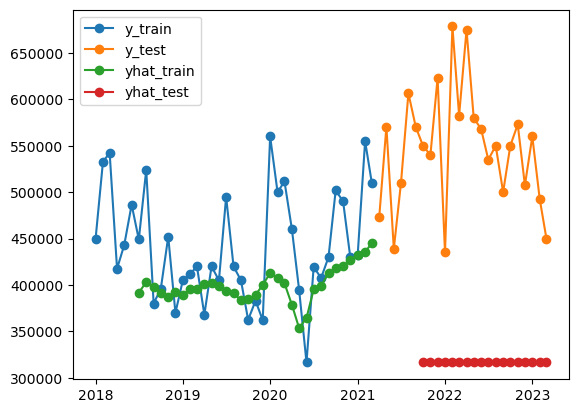

district_no 7
Epoch 1/20


2023-04-06 18:08:48.488031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:49.340852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:49.647715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:49.932833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:50.300020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:50.645182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:08:50.990514: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 124ms/step - loss: 0.1819
Epoch 2/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1626
Epoch 3/20
33/33 [==============================] - 3s 81ms/step - loss: 0.1574
Epoch 4/20
33/33 [==============================] - 3s 82ms/step - loss: 0.1573
Epoch 5/20
33/33 [==============================] - 3s 77ms/step - loss: 0.1556
Epoch 6/20
33/33 [==============================] - 3s 81ms/step - loss: 0.1570
Epoch 7/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1658
Epoch 8/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1547
Epoch 9/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1539
Epoch 10/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1562
Epoch 11/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1534
Epoch 12/20
33/33 [==============================] - 3s 84ms/step - loss: 0.1525
Epoch 13/20
33/33 [===========================

2023-04-06 18:09:46.678184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:47.201015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:47.382287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:19

2023-04-06 18:09:47.563334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 170373.66 RMSE
Test Score: 478284.92 RMSE


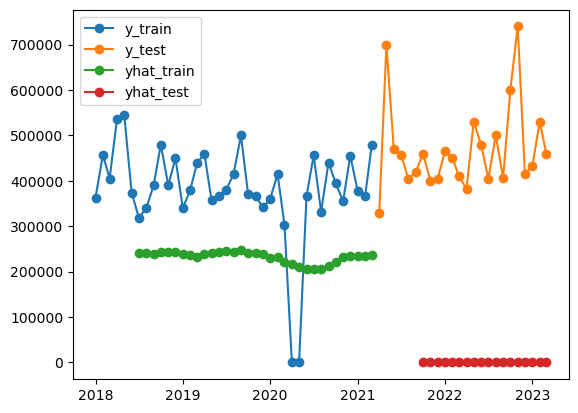

district_no 8
Epoch 1/20


2023-04-06 18:09:55.695004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:56.558454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:56.816240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:57.075000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:57.431270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:57.745560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:09:58.057197: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 12s 142ms/step - loss: 0.1702
Epoch 2/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1321
Epoch 3/20
33/33 [==============================] - 3s 82ms/step - loss: 0.1314
Epoch 4/20
33/33 [==============================] - 3s 82ms/step - loss: 0.1311
Epoch 5/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1298
Epoch 6/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1335
Epoch 7/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1345
Epoch 8/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1300
Epoch 9/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1282
Epoch 10/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1312
Epoch 11/20
33/33 [==============================] - 3s 81ms/step - loss: 0.1303
Epoch 12/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1296
Epoch 13/20
33/33 [===========================

2023-04-06 18:10:54.090293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:10:54.576849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:10:54.754058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:17

2023-04-06 18:10:54.909585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 181001.03 RMSE
Test Score: 572042.35 RMSE


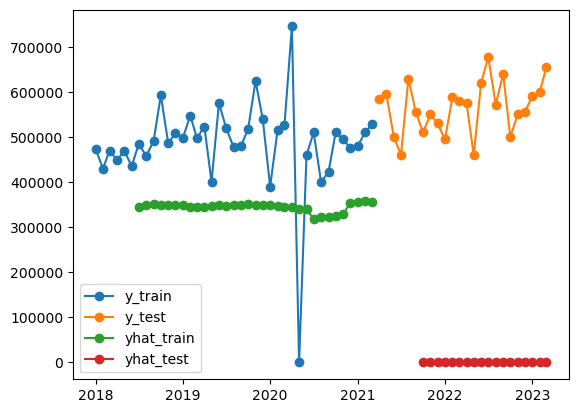

district_no 10
Epoch 1/20


2023-04-06 18:11:03.256233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:04.156240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:04.443084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:04.725850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:05.098434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:05.412245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:05.723858: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 64ms/step - loss: 0.0744
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0649
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0643
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0653
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0637
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0640
Epoch 7/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0641
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0635
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0644
Epoch 10/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0651
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0634
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0633
Epoch 13/20
33/33 [============================

2023-04-06 18:11:34.706230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:35.220423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:35.386545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:35.563022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 59687.77 RMSE
Test Score: 275993.26 RMSE


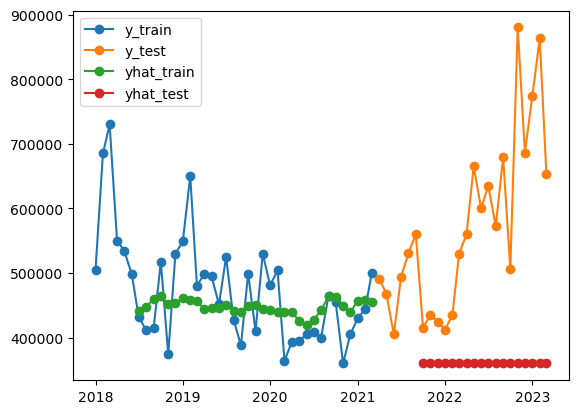

district_no 11
Epoch 1/20


2023-04-06 18:11:43.585401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:44.493385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:44.843811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:45.186049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:45.593490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:45.980379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:11:46.346245: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 14s 354ms/step - loss: 0.1280
Epoch 2/20
21/21 [==============================] - 6s 283ms/step - loss: 0.1227
Epoch 3/20
21/21 [==============================] - 6s 282ms/step - loss: 0.1181
Epoch 4/20
21/21 [==============================] - 6s 305ms/step - loss: 0.1197
Epoch 5/20
21/21 [==============================] - 6s 282ms/step - loss: 0.1115
Epoch 6/20
21/21 [==============================] - 6s 279ms/step - loss: 0.1083
Epoch 7/20
21/21 [==============================] - 6s 279ms/step - loss: 0.1104
Epoch 8/20
21/21 [==============================] - 6s 277ms/step - loss: 0.1075
Epoch 9/20
21/21 [==============================] - 6s 290ms/step - loss: 0.1038
Epoch 10/20
21/21 [==============================] - 6s 277ms/step - loss: 0.1003
Epoch 11/20
21/21 [==============================] - 6s 279ms/step - loss: 0.1005
Epoch 12/20
21/21 [==============================] - 6s 277ms/step - loss: 0.0948
Epoch 13/20
21/21 [================

2023-04-06 18:13:48.539470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:49.054634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:49.276787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:49.478286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 41ms/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
Train Score: 223661.79 RMSE
Test Score: 250991.04 RMSE
model for district 11 cannot be evaluated
district_no 12
Epoch 1/20


2023-04-06 18:13:57.387201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:58.246636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:58.502370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:58.766585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:59.133902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:59.464188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:13:59.780841: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 9s 64ms/step - loss: 0.1133
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0944
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0959
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0928
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0921
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0931
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0925
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0930
Epoch 9/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0901
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0905
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0916
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0923
Epoch 13/20
33/33 [=============================

2023-04-06 18:14:29.176613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:29.698920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:29.877523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:20

2023-04-06 18:14:30.091819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 97631.14 RMSE
Test Score: 346430.90 RMSE


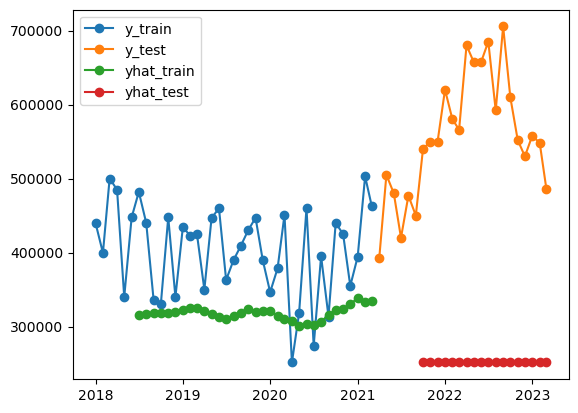

district_no 13
Epoch 1/20


2023-04-06 18:14:38.035238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:38.925852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:39.196163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:39.462336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:39.819021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:40.123403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:14:40.425783: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 64ms/step - loss: 0.0868
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0747
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0707
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0722
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0727
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0716
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0741
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0713
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0699
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0698
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0685
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0682
Epoch 13/20
33/33 [============================

2023-04-06 18:15:09.854860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:10.336045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:10.513268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 1:15

2023-04-06 18:15:10.664212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 89181.49 RMSE
Test Score: 223126.43 RMSE


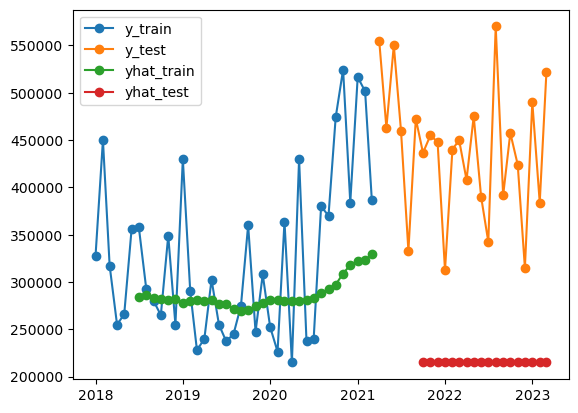

district_no 14
Epoch 1/20


2023-04-06 18:15:18.124064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:19.014426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:19.290989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:19.546462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:19.897362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:20.217276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:20.522047: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 9s 72ms/step - loss: 0.0965
Epoch 2/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0832
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0830
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0832
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0829
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0829
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0818
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0807
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0813
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0809
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0822
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0812
Epoch 13/20
33/33 [=============================

2023-04-06 18:15:51.381711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:52.035783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:15:52.264948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/33 [..............................] - ETA: 2:10

2023-04-06 18:15:52.481327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 64747.54 RMSE
Test Score: 200349.75 RMSE


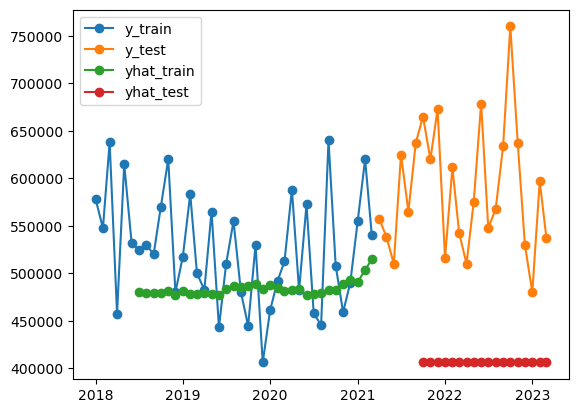

district_no 15
Epoch 1/20


2023-04-06 18:15:59.214119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:00.102309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:00.422256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:00.678519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:01.031521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:01.468347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:01.839177: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 76ms/step - loss: 0.1249
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1011
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1004
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0988
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1007
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0995
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0992
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0976
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0986
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0991
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0982
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0970
Epoch 13/20
33/33 [============================

2023-04-06 18:16:31.672913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:32.198543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:32.363338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:32.556231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 63133.37 RMSE
Test Score: 166301.78 RMSE


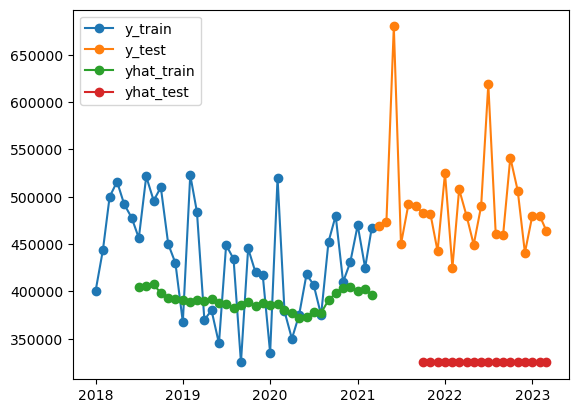

district_no 16
Epoch 1/20


2023-04-06 18:16:40.628568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:41.539374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:41.833829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:42.167837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:42.632957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:42.965500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:16:43.362207: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 79ms/step - loss: 0.1015
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0775
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0813
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0765
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0809
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0757
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0772
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0748
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0748
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0751
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0753
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0750
Epoch 13/20
33/33 [============================

2023-04-06 18:17:13.580253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:14.117038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:14.347157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:14.640028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21513.47 RMSE
Test Score: 122154.39 RMSE


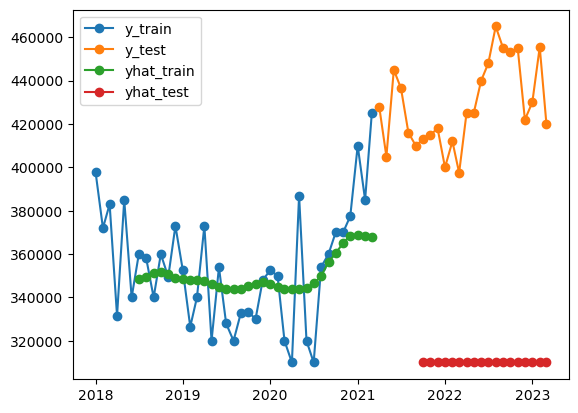

district_no 17
Epoch 1/20


2023-04-06 18:17:22.463742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:23.454403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:23.928620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:24.297122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:24.845568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:25.223966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:17:25.649314: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 20s 371ms/step - loss: 0.1376
Epoch 2/20
33/33 [==============================] - 10s 291ms/step - loss: 0.1378
Epoch 3/20
33/33 [==============================] - 9s 287ms/step - loss: 0.1324
Epoch 4/20
33/33 [==============================] - 9s 287ms/step - loss: 0.1288
Epoch 5/20
33/33 [==============================] - 9s 283ms/step - loss: 0.1283
Epoch 6/20
33/33 [==============================] - 9s 284ms/step - loss: 0.1220
Epoch 7/20
33/33 [==============================] - 10s 294ms/step - loss: 0.1217
Epoch 8/20
33/33 [==============================] - 9s 280ms/step - loss: 0.1235
Epoch 9/20
33/33 [==============================] - 9s 283ms/step - loss: 0.1196
Epoch 10/20
33/33 [==============================] - 9s 280ms/step - loss: 0.1128
Epoch 11/20
33/33 [==============================] - 9s 280ms/step - loss: 0.1167
Epoch 12/20
33/33 [==============================] - 9s 281ms/step - loss: 0.1082
Epoch 13/20
33/33 [==============

2023-04-06 18:20:37.913274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:38.397115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:38.736213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:39.055027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 43ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 134165.65 RMSE
Test Score: 246199.22 RMSE


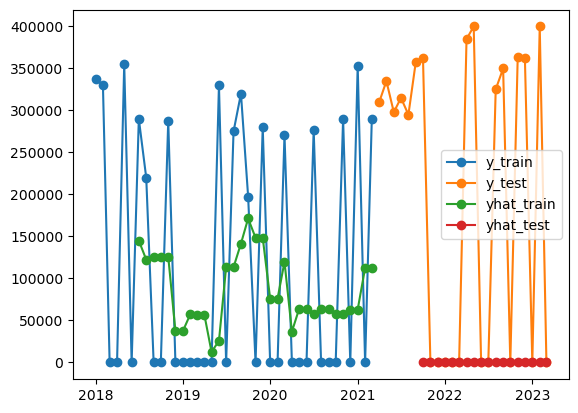

district_no 18
Epoch 1/20


2023-04-06 18:20:49.286780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:50.227138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:50.579745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:50.910670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:51.372290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:51.793154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:20:52.201974: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 91ms/step - loss: 0.1121
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1035
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1038
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1023
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1016
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1006
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1009
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0993
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1022
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0990
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0996
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0991
Epoch 13/20
33/33 [============================

2023-04-06 18:21:24.367390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:24.978514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:25.208099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:25.463391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21601.17 RMSE
Test Score: 134166.01 RMSE


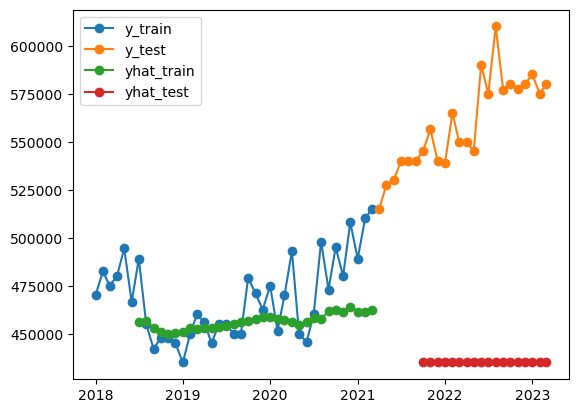

district_no 19
Epoch 1/20


2023-04-06 18:21:32.830706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:33.728801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:34.097896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:34.461433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:34.958413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:35.395514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:21:35.831490: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 94ms/step - loss: 0.0993
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0885
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0879
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0871
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0868
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0883
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0873
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0864
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0855
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0860
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0856
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0855
Epoch 13/20
33/33 [============================

2023-04-06 18:22:06.832213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:07.354877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:07.628319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:07.894302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 13973.15 RMSE
Test Score: 127446.46 RMSE


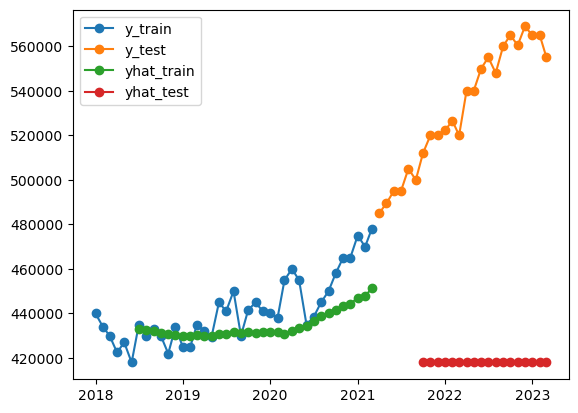

district_no 20
Epoch 1/20


2023-04-06 18:22:16.378355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:17.509526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:17.914074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:18.275686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:18.784845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:19.215888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:19.633737: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 12s 93ms/step - loss: 0.1241
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0985
Epoch 3/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0973
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0971
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0961
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0950
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0965
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0977
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0954
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0943
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0940
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0955
Epoch 13/20
33/33 [============================

2023-04-06 18:22:49.759109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:50.319834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:50.569654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:50.807548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 39530.25 RMSE
Test Score: 180012.60 RMSE


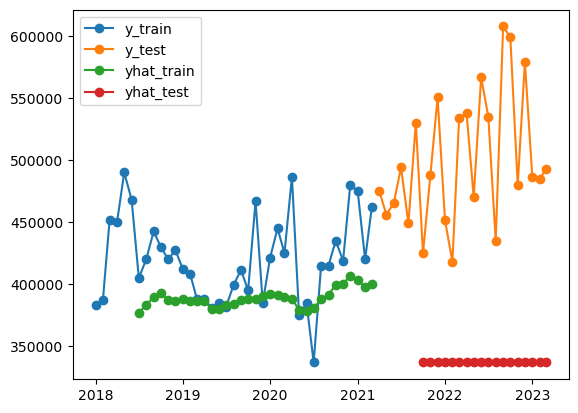

district_no 21
Epoch 1/20


2023-04-06 18:22:58.697917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:22:59.637079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:00.006238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:00.349630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:00.823573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:01.249959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:01.676386: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 93ms/step - loss: 0.1570
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1392
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1379
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1398
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1385
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1376
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1366
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1372
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1369
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1378
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1385
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1366
Epoch 13/20
33/33 [============================

2023-04-06 18:23:32.237117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:32.830406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:33.094330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:33.326857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 294342.27 RMSE
Test Score: 532719.12 RMSE


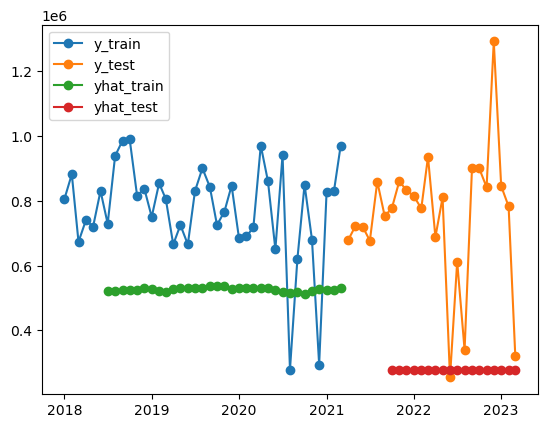

district_no 22
Epoch 1/20


2023-04-06 18:23:41.702169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:42.595055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:42.943396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:43.280908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:43.754997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:44.177012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:23:44.611718: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 95ms/step - loss: 0.1086
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0972
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0916
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0920
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0913
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0917
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0920
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0903
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0910
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0891
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0895
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0893
Epoch 13/20
33/33 [============================

2023-04-06 18:24:16.982613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:17.556228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:17.801309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:18.046709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22548.37 RMSE
Test Score: 124156.83 RMSE


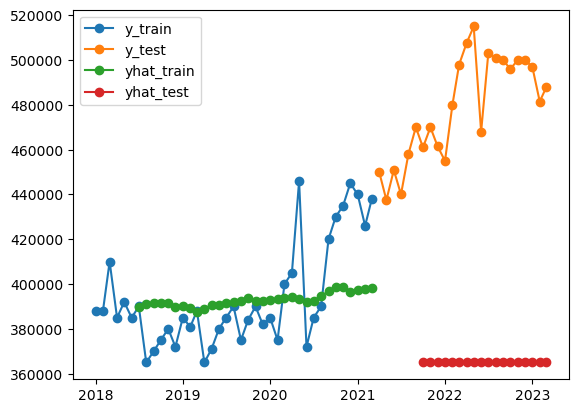

district_no 23
Epoch 1/20


2023-04-06 18:24:25.703115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:26.689921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:27.078277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:27.474010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:27.997007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:28.416772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:28.838651: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 94ms/step - loss: 0.1270
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1011
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0977
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0983
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0992
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1009
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0982
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0978
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0979
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1003
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0982
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0976
Epoch 13/20
33/33 [============================

2023-04-06 18:24:59.412718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:24:59.911918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:00.152485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:00.418366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24376.34 RMSE
Test Score: 159013.19 RMSE


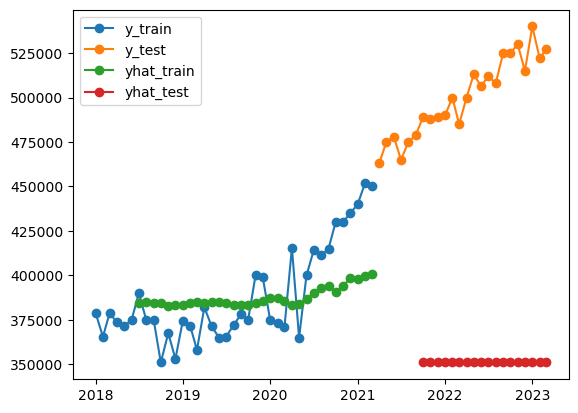

district_no 25
Epoch 1/20


2023-04-06 18:25:09.413795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:10.349283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:10.731984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:11.094883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:11.578550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:11.986560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:12.410275: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 12s 95ms/step - loss: 0.1046
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0957
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0945
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0955
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0936
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0958
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0941
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0951
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0947
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0954
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0949
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0942
Epoch 13/20
33/33 [============================

2023-04-06 18:25:43.176243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:43.734452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:43.998026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:44.253228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24388.81 RMSE
Test Score: 164809.10 RMSE


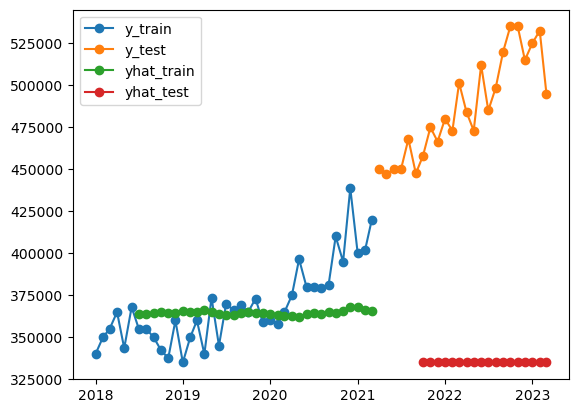

district_no 27
Epoch 1/20


2023-04-06 18:25:52.281887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:53.233870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:53.586002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:53.952335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:54.440585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:54.843316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:25:55.261538: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 93ms/step - loss: 0.1576
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1317
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1313
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1328
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1303
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1302
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1300
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1312
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1298
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1293
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1315
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1306
Epoch 13/20
33/33 [============================

2023-04-06 18:26:26.011734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:26.562305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:26.855610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:27.077184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 26165.30 RMSE
Test Score: 146544.76 RMSE


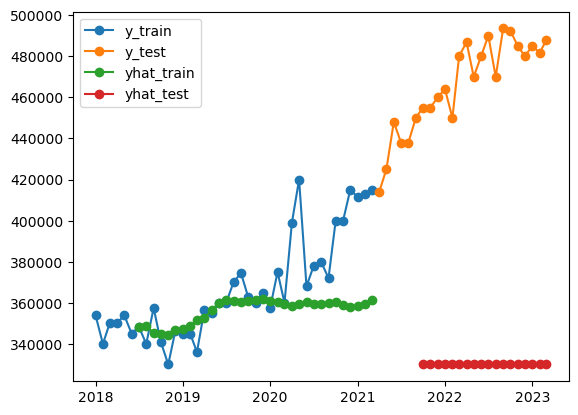

district_no 28
Epoch 1/20


2023-04-06 18:26:35.471248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:36.412644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:36.779939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:37.129418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:37.606659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:38.018756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:26:38.429266: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 93ms/step - loss: 0.1284
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1000
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0978
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0964
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0959
Epoch 6/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0951
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0964
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0948
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0950
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0949
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0946
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0941
Epoch 13/20
33/33 [============================

2023-04-06 18:27:10.665414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:11.198041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:11.459564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:11.691809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 15491.40 RMSE
Test Score: 131064.18 RMSE


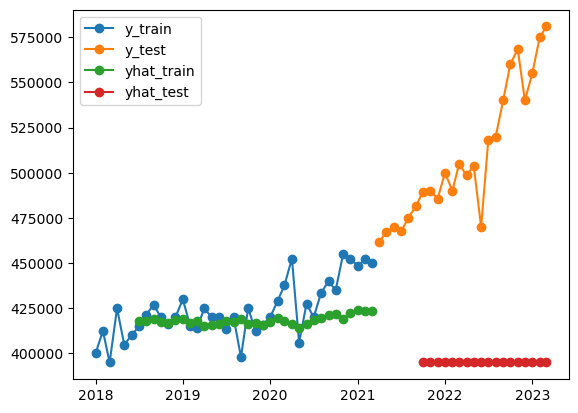

In [25]:
# run the model for all districts
district_no_list = list(train_lstm_df_dict.keys())
test_score_dict = {}
for district_no in district_no_list:
    print("district_no", district_no)
    model = fit_lstm(train_lstm_dataset_dict[district_no])
    test_score = evaluate_lstm(
        model=model,
        X_train=train_lstm_dataset_dict[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict[district_no] = test_score       

In [26]:
test_score_dict

{1: 452249.18831694254,
 2: 942151.447460545,
 3: 187180.71654479322,
 4: 270948.2255864475,
 5: 244527.71940120726,
 7: 478284.91573119885,
 8: 572042.3544482233,
 10: 275993.260684226,
 11: None,
 12: 346430.9018112815,
 13: 223126.4277887713,
 14: 200349.74969898126,
 15: 166301.78306190658,
 16: 122154.38774126963,
 17: 246199.21737949896,
 18: 134166.00738554375,
 19: 127446.458078154,
 20: 180012.6032970408,
 21: 532719.1249721668,
 22: 124156.82760480347,
 23: 159013.18952981368,
 25: 164809.1000049586,
 27: 146544.76452606556,
 28: 131064.1789930075}

# LSTM Model with linear interpolation

district_no 1 linear interpolation applied
Epoch 1/20


2023-04-06 18:27:19.265799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:20.296298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:20.673815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:21.044996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:21.570584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:21.995551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:22.433038: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 96ms/step - loss: 0.0877
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0775
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0748
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0735
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0738
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0731
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0747
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0725
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0773
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0736
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0730
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0729
Epoch 13/20
33/33 [============================

2023-04-06 18:27:53.503385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:54.072469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:54.290539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:27:54.642238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 57ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 59267.28 RMSE
Test Score: 149832.67 RMSE


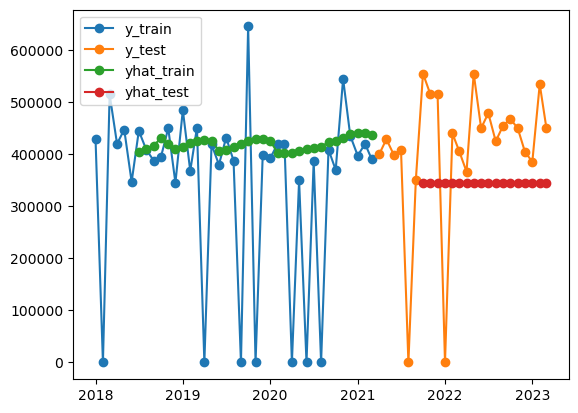

district_no 2 linear interpolation applied
Epoch 1/20


2023-04-06 18:28:04.630557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:05.627550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:05.991985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:06.349464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:06.815335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:07.220715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:07.616418: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 12s 95ms/step - loss: 0.1375
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1200
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1168
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1184
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1164
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1160
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1166
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1140
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1163
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1148
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1153
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1126
Epoch 13/20
33/33 [============================

2023-04-06 18:28:38.648549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:39.212880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:39.477658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:39.815464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 184939.18 RMSE
Test Score: 481880.60 RMSE


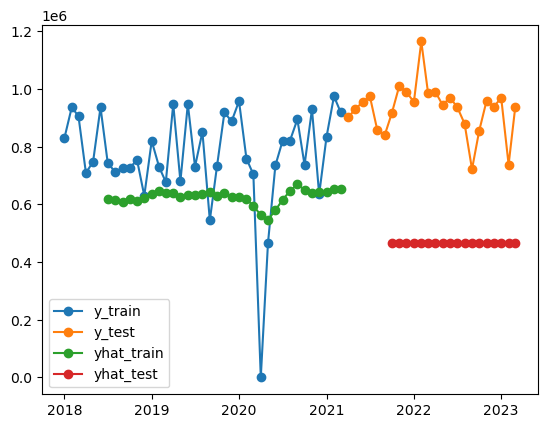

district_no 3 linear interpolation applied
Epoch 1/20


2023-04-06 18:28:47.915126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:48.947058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:49.363817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:49.712393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:50.198746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:50.591446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:28:51.015584: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 92ms/step - loss: 0.1193
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0952
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0934
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0932
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0934
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0948
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0932
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0924
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0944
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0926
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0936
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0933
Epoch 13/20
33/33 [============================

2023-04-06 18:29:21.939365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:22.541044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:22.792651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:23.007380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 62558.04 RMSE
Test Score: 187180.72 RMSE


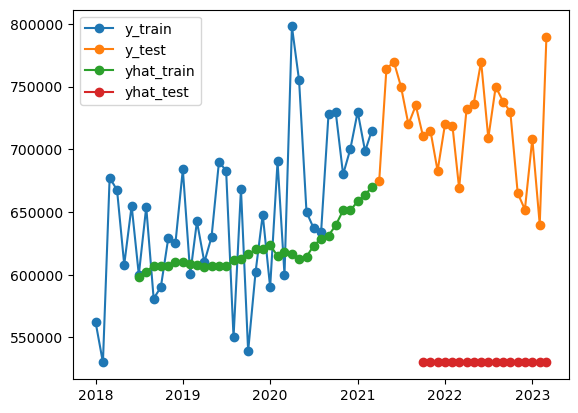

district_no 4 linear interpolation applied
Epoch 1/20


2023-04-06 18:29:32.280627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:33.326610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:33.714726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:34.063267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:34.561243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:35.003142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:29:35.428744: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 10s 92ms/step - loss: 0.0891
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0803
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0800
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0798
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0799
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0794
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0802
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0786
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0795
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0803
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0804
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0795
Epoch 13/20
33/33 [============================

2023-04-06 18:30:08.079675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:08.822572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:09.066734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:09.319600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 80003.01 RMSE
Test Score: 270948.23 RMSE


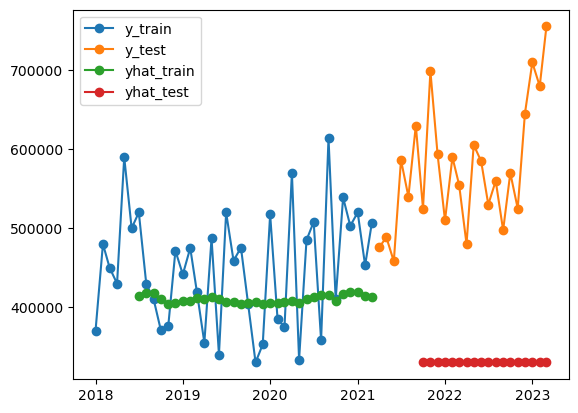

district_no 5 linear interpolation applied
Epoch 1/20


2023-04-06 18:30:16.775164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:17.736585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:18.103751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:18.435152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:18.924641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:19.413928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:19.837267: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 94ms/step - loss: 0.1169
Epoch 2/20
33/33 [==============================] - 2s 65ms/step - loss: 0.0994
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0978
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0979
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0958
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0966
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0969
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0963
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0950
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0957
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0936
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0942
Epoch 13/20
33/33 [============================

2023-04-06 18:30:51.911431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:52.488249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:52.767794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:30:53.078785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 66607.57 RMSE
Test Score: 244527.72 RMSE


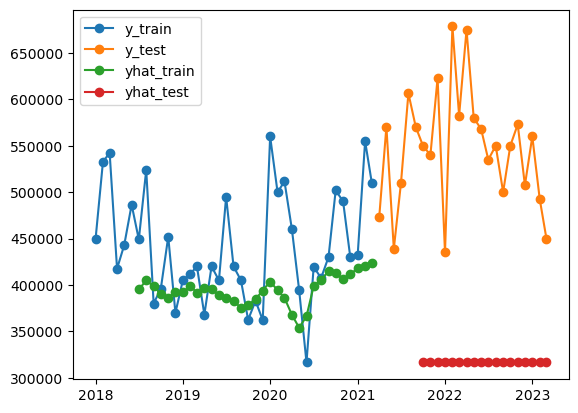

district_no 7 linear interpolation applied
Epoch 1/20


2023-04-06 18:31:01.876766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:03.081507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:03.467517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:03.869803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:04.635358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:05.235542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:05.809859: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 13s 101ms/step - loss: 0.1080
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0900
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0919
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0901
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0908
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0901
Epoch 7/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0899
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0891
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0901
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0900
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0902
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0905
Epoch 13/20
33/33 [===========================

2023-04-06 18:31:38.464888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:39.075783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:39.322270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:39.723775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 49864.73 RMSE
Test Score: 188147.55 RMSE


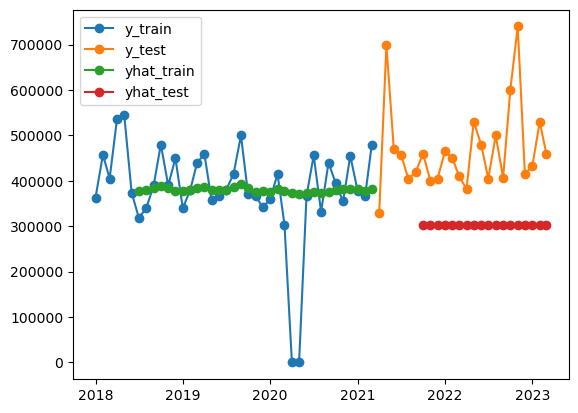

district_no 8 linear interpolation applied
Epoch 1/20


2023-04-06 18:31:47.814425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:48.882915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:49.325383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:49.718048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:50.428810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:50.874861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:31:51.299211: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 12s 102ms/step - loss: 0.1080
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0879
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0870
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0892
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0873
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0875
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0867
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0871
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0873
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0876
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0860
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0857
Epoch 13/20
33/33 [===========================

2023-04-06 18:32:22.526603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:23.160896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:23.447333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:23.739400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 65291.77 RMSE
Test Score: 187852.82 RMSE


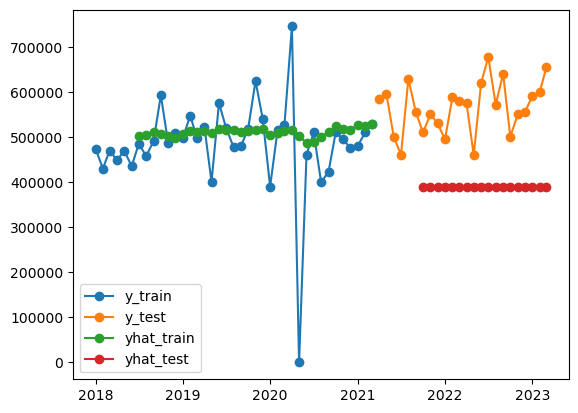

district_no 10 linear interpolation applied
Epoch 1/20


2023-04-06 18:32:32.379974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:33.407172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:33.850224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:34.214851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:34.702975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:35.295383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:32:35.716258: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 11s 110ms/step - loss: 0.0744
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0647
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0642
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0637
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0637
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0641
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0635
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0638
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0636
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0640
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0636
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0636
Epoch 13/20
33/33 [===========================

2023-04-06 18:33:08.592524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:09.234909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:09.574367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:09.987619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 60170.70 RMSE
Test Score: 275993.26 RMSE


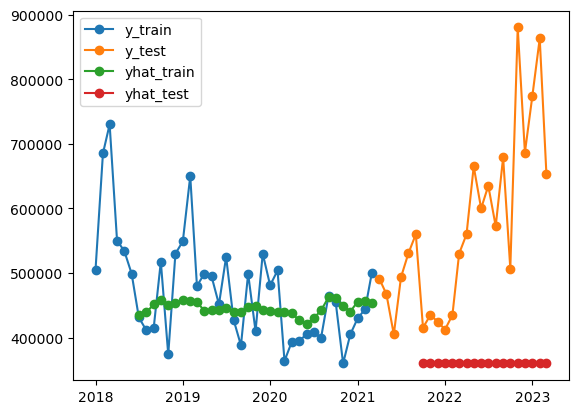

district_no 11 linear interpolation applied
Epoch 1/20


2023-04-06 18:33:18.009844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:19.032453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:19.516723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:19.999050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:20.688605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:21.226806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:21.732159: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 12s 167ms/step - loss: nan
Epoch 2/20
21/21 [==============================] - 1s 67ms/step - loss: nan
Epoch 3/20
21/21 [==============================] - 1s 50ms/step - loss: nan
Epoch 4/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 5/20
21/21 [==============================] - 1s 45ms/step - loss: nan
Epoch 6/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 7/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 8/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 9/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 10/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 11/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoch 12/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 13/20
21/21 [==============================] - 1s 41ms/step - loss: nan
Epoc

2023-04-06 18:33:44.546853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:45.065724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:45.387507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:45.804340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 112ms/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
model for district 11 cannot be evaluated
district_no 12 linear interpolation applied
Epoch 1/20


2023-04-06 18:33:57.283069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:58.499796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:58.921425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:33:59.463801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:00.219737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:00.801723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:01.408908: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 129ms/step - loss: 0.1035
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0917
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0963
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0911
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0941
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0910
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0935
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0934
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0902
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0909
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0923
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0941
Epoch 13/20
33/33 [===========================

2023-04-06 18:34:33.818763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:34.436760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:34.856365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:35.296009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 86899.49 RMSE
Test Score: 346430.90 RMSE


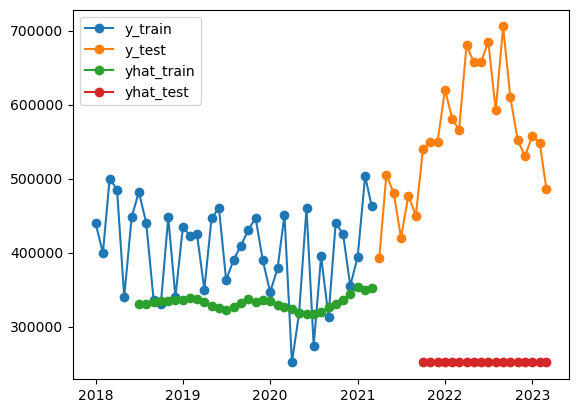

district_no 13 linear interpolation applied
Epoch 1/20


2023-04-06 18:34:43.813455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:44.870336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:45.356677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:45.905140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:46.591665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:47.137906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:34:47.692582: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 131ms/step - loss: 0.0908
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0737
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0718
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0713
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0683
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0666
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0684
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0728
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0699
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0697
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0672
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0672
Epoch 13/20
33/33 [===========================

2023-04-06 18:35:19.942606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:20.610465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:20.979606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:21.282695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 75972.48 RMSE
Test Score: 223126.43 RMSE


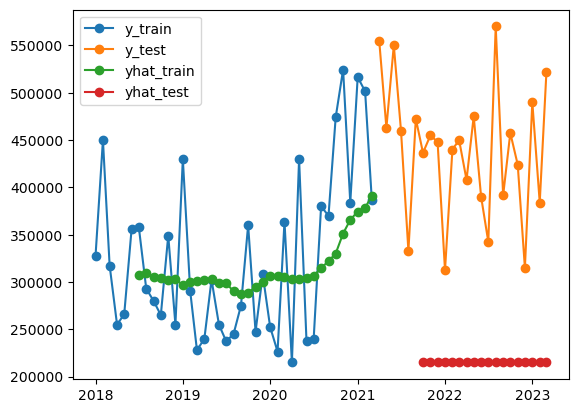

district_no 14 linear interpolation applied
Epoch 1/20


2023-04-06 18:35:30.452157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:31.501310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:32.091911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:32.568007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:33.281612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:33.880626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:35:34.451261: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 137ms/step - loss: 0.0915
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0819
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0836
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0826
Epoch 5/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0820
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0827
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0819
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0816
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0829
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0809
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0819
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0812
Epoch 13/20
33/33 [===========================

2023-04-06 18:36:07.114454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:07.757985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:08.177574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:08.610232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 74926.22 RMSE
Test Score: 200349.75 RMSE


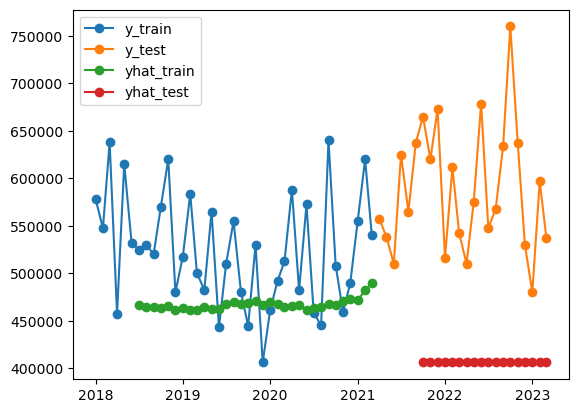

district_no 15 linear interpolation applied
Epoch 1/20


2023-04-06 18:36:17.306184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:18.312208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:18.865506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:19.345665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:20.053120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:20.700687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:21.264581: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 13s 151ms/step - loss: 0.1144
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1023
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1014
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1014
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1020
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1010
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0992
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1011
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0983
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0976
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0992
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0965
Epoch 13/20
33/33 [===========================

2023-04-06 18:36:55.822373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:56.649923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:57.065839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:36:57.470180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 59706.38 RMSE
Test Score: 166301.78 RMSE


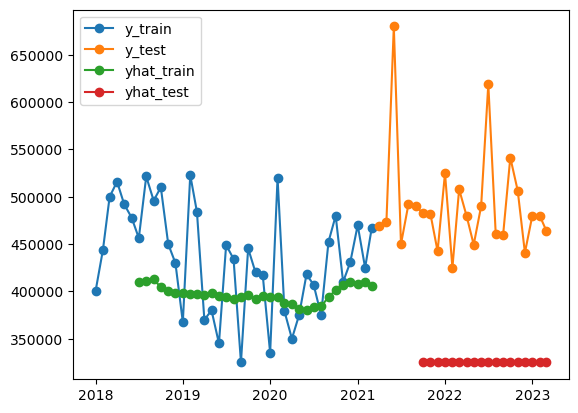

district_no 16 linear interpolation applied
Epoch 1/20


2023-04-06 18:37:05.933723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:07.037456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:07.603662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:08.139184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:08.890101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:09.482275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:10.111239: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 145ms/step - loss: 0.1032
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0785
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0772
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0761
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0761
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0768
Epoch 7/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0766
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0756
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0759
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0750
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0754
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0748
Epoch 13/20
33/33 [===========================

2023-04-06 18:37:42.980055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:43.586346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:44.077310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:44.471217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21838.11 RMSE
Test Score: 122154.39 RMSE


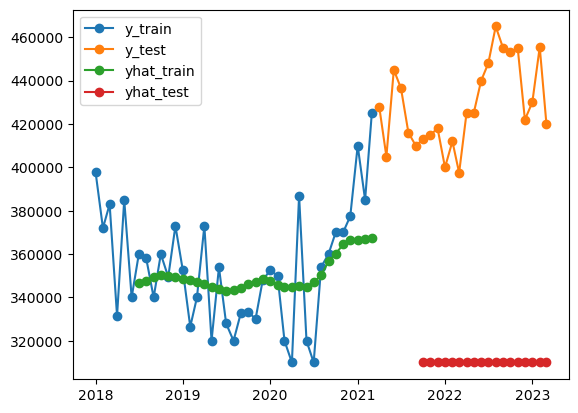

district_no 17 linear interpolation applied
Epoch 1/20


2023-04-06 18:37:54.025351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:55.085674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:55.662774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:56.204298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:56.937251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:57.534988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:37:58.128080: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 146ms/step - loss: 0.0792
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0727
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0718
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0712
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0701
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0698
Epoch 7/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0696
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0699
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0695
Epoch 11/20
33/33 [==============================] - 1s 39ms/step - loss: 0.0692
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0693
Epoch 13/20
33/33 [===========================

2023-04-06 18:38:30.748700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:31.433717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:31.907563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:32.370290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 152ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 65909.13 RMSE
Test Score: 186879.82 RMSE


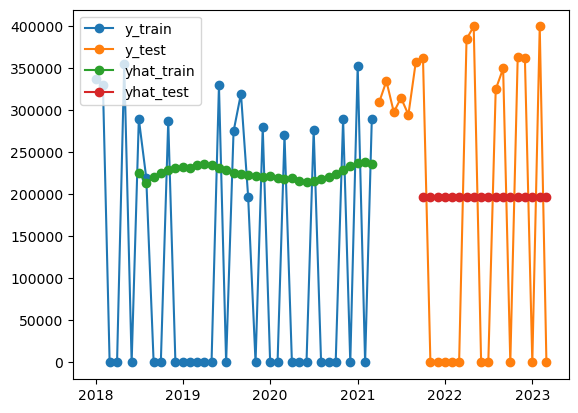

district_no 18 linear interpolation applied
Epoch 1/20


2023-04-06 18:38:43.663155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:44.729926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:45.323594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:45.764711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:46.497089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:47.094696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:38:47.737673: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 146ms/step - loss: 0.1161
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1067
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1018
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1019
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1014
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1042
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1012
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1018
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1003
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0994
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0993
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0995
Epoch 13/20
33/33 [===========================

2023-04-06 18:39:20.270205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:20.927384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:21.283749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:21.714618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21573.52 RMSE
Test Score: 134166.01 RMSE


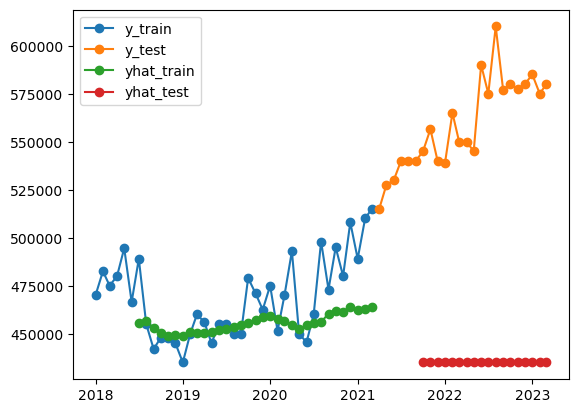

district_no 19 linear interpolation applied
Epoch 1/20


2023-04-06 18:39:31.790917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:32.831957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:33.434824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:33.937885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:34.717513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:35.322112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:39:35.924309: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 13s 145ms/step - loss: 0.1008
Epoch 2/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0906
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0880
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0858
Epoch 5/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0866
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0867
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0867
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0860
Epoch 9/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0860
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0861
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0857
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0854
Epoch 13/20
33/33 [===========================

2023-04-06 18:40:08.501885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:09.198972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:09.622087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:10.086979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 13786.46 RMSE
Test Score: 127446.46 RMSE


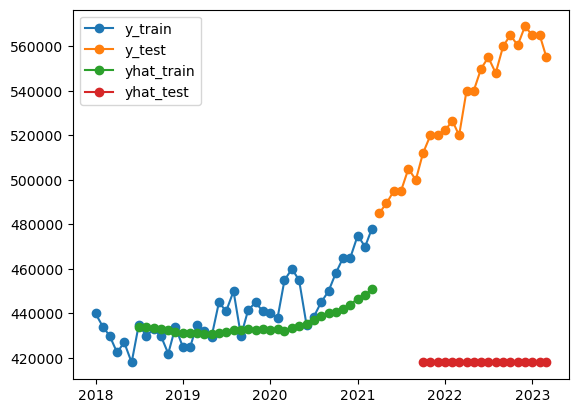

district_no 20 linear interpolation applied
Epoch 1/20


2023-04-06 18:40:18.911379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:19.968377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:20.557571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:21.080712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:21.805010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:22.402379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:23.083129: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 13s 150ms/step - loss: 0.1197
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0970
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0971
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0963
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0964
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0975
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0964
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0961
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0952
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0949
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0960
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0963
Epoch 13/20
33/33 [===========================

2023-04-06 18:40:57.824708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:58.500023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:58.939411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:40:59.360378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 36712.22 RMSE
Test Score: 180012.60 RMSE


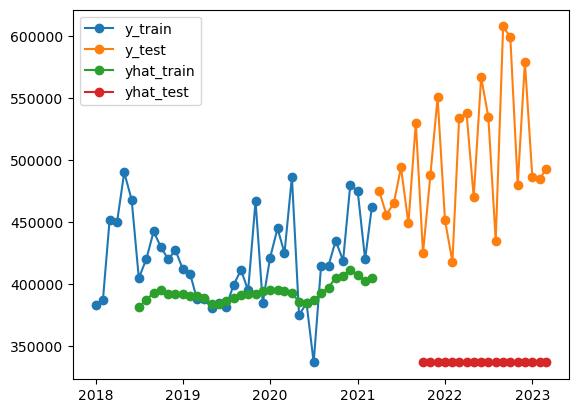

district_no 21 linear interpolation applied
Epoch 1/20


2023-04-06 18:41:07.816524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:08.925644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:09.574298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:10.071354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:10.861816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:11.488834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:12.134510: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 151ms/step - loss: 0.1630
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1379
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1391
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1369
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1402
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1376
Epoch 7/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1372
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1378
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1380
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1379
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1381
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1364
Epoch 13/20
33/33 [===========================

2023-04-06 18:41:45.223862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:45.859790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:46.214280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:46.811771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 286911.17 RMSE
Test Score: 532719.12 RMSE


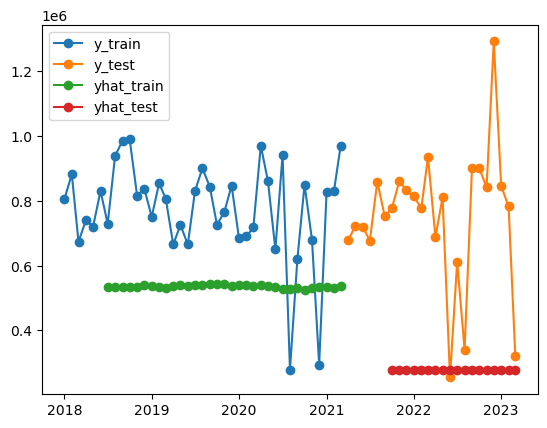

district_no 22 linear interpolation applied
Epoch 1/20


2023-04-06 18:41:56.421801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:57.537478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:58.176990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:58.679543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:41:59.502531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:00.160078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:00.760616: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 151ms/step - loss: 0.1072
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0941
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0904
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0913
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0901
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0918
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0904
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0911
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0907
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0916
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0942
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0900
Epoch 13/20
33/33 [===========================

2023-04-06 18:42:33.832568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:34.464181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:34.920457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:35.374823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21967.21 RMSE
Test Score: 124156.83 RMSE


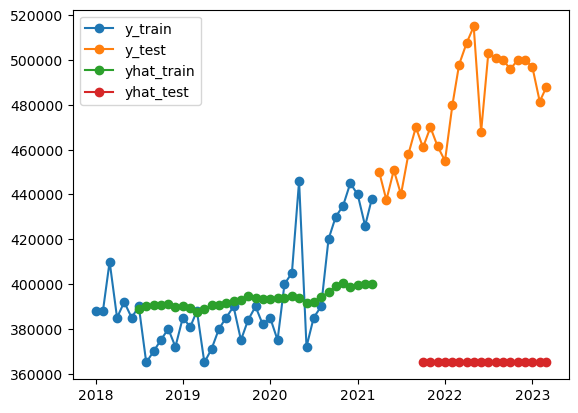

district_no 23 linear interpolation applied
Epoch 1/20


2023-04-06 18:42:44.246855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:45.340577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:45.874707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:46.440411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:47.194647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:47.826394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:42:48.439714: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 15s 152ms/step - loss: 0.1340
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1012
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0990
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0996
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0978
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0975
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1034
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0978
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0967
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0980
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0974
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0978
Epoch 13/20
33/33 [===========================

2023-04-06 18:43:21.618272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:22.370498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:22.894126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:23.252890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 26025.54 RMSE
Test Score: 159013.19 RMSE


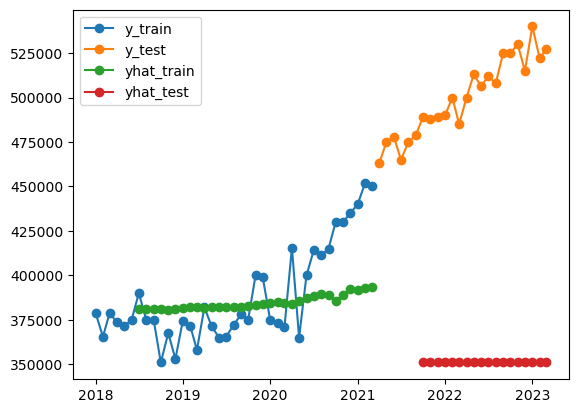

district_no 25 linear interpolation applied
Epoch 1/20


2023-04-06 18:43:33.049096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:34.142171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:34.741552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:35.286056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:36.094679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:36.771225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:43:37.403140: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 153ms/step - loss: 0.1054
Epoch 2/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0965
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0946
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0953
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0951
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0942
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0943
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0948
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0954
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0942
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0941
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0947
Epoch 13/20
33/33 [===========================

2023-04-06 18:44:12.512875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:13.184581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:13.621122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:14.037260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 23990.75 RMSE
Test Score: 164809.10 RMSE


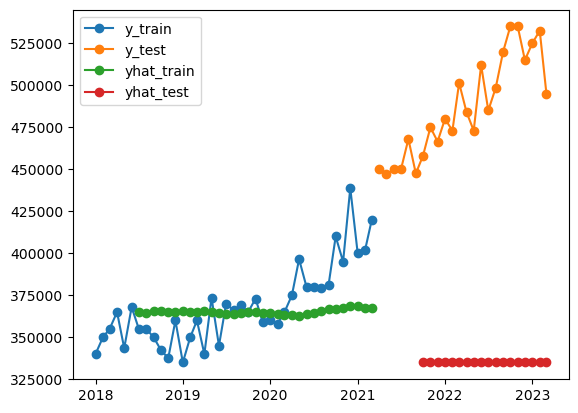

district_no 27 linear interpolation applied
Epoch 1/20


2023-04-06 18:44:22.366328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:23.439771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:24.015939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:24.568475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:25.328436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:26.007685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:44:26.673161: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 14s 154ms/step - loss: 0.1467
Epoch 2/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1366
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1308
Epoch 4/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1313
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1313
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1313
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1294
Epoch 8/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1299
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1295
Epoch 10/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1306
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1291
Epoch 12/20
33/33 [==============================] - 1s 40ms/step - loss: 0.1291
Epoch 13/20
33/33 [===========================

2023-04-06 18:44:59.641550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:00.216450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:00.611133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:01.030959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 23725.93 RMSE
Test Score: 146544.76 RMSE


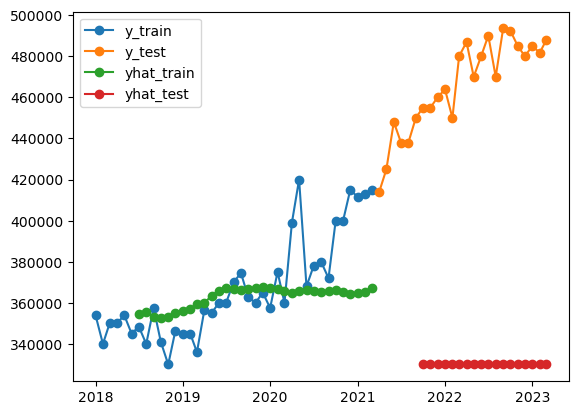

district_no 28 linear interpolation applied
Epoch 1/20


2023-04-06 18:45:11.265851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:12.291270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:13.025119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:13.578295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:14.363070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:15.039359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:15.700728: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 156ms/step - loss: 0.1125
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0980
Epoch 3/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0961
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0961
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0987
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0964
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0972
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0948
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0968
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0954
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0943
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0938
Epoch 13/20
33/33 [===========================

2023-04-06 18:45:49.550290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:50.278096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:50.728533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 18:45:51.248018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 18046.71 RMSE
Test Score: 131064.18 RMSE


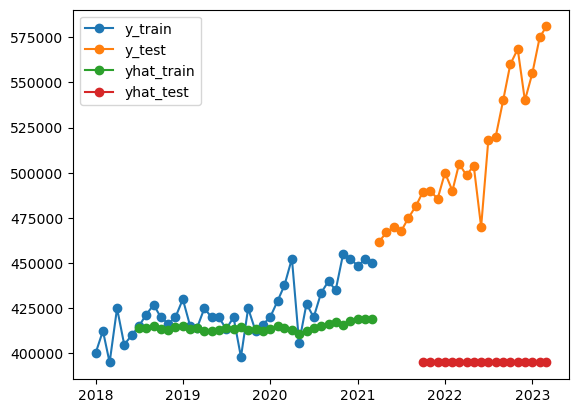

In [27]:
def fit_lstm_L(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model

def evaluate_lstm_L(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict_L[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict_L[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict_L[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    try:
        train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
        print('Train Score: %.2f RMSE' % (train_score))
        test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
        print('Test Score: %.2f RMSE' % (test_score))
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score

# run the model for all districts with linear interpolation applied to the missing values
district_no_list = list(train_lstm_df_dict_L.keys())
test_score_dict_LI = {}

for district_no in district_no_list:
    print("district_no", district_no, "linear interpolation applied")
    model = fit_lstm_L(train_lstm_dataset_dict_L[district_no])
    test_score = evaluate_lstm_L(
        model=model,
        X_train=train_lstm_dataset_dict_L[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict_LI[district_no] = test_score 

# Evaluation

In [44]:
evaluations_df = pd.read_csv("eval/SARIMA_SARIMAX_evaluations.csv", index_col=0)

with open("eval/test_score_dict_lstm.pkl", "wb") as f:
    pickle.dump(test_score_dict, f)

with open("eval/test_score_dict_lstm.pkl", "wb") as f:
    pickle.dump(test_score_dict_LI, f)

evaluations_df["LSTM"] = pd.Series(test_score_dict)
evaluations_df["LSTM_LI"] = pd.Series(test_score_dict_LI)


# Poor performance of LSTM

In [45]:
evaluations_df

,RMSE_SARIMAX,RMSE_SARIMAX_L,RMSE_SARIMA,RMSE_SARIMA_L,RMSE_Baseline,Best Model,LSTM,LSTM_LI
1,55011.419620,80023.212541,80701.954465,80023.212541,80023.212541,['RMSE_SARIMAX'],452249.188317,149832.667778
2,165305.580841,169804.966230,165305.580841,169804.966230,104978.301266,['RMSE_Baseline'],942151.447461,481880.597194
3,46309.954068,46309.954068,46309.954068,46309.954068,50876.392390,"['RMSE_SARIMAX', 'RMSE_SARIMAX_L', 'RMSE_SARIM...",187180.716545,187180.716545
4,71366.794416,71366.794416,71366.794416,71366.794416,81127.689438,"['RMSE_SARIMAX', 'RMSE_SARIMAX_L', 'RMSE_SARIM...",270948.225586,270948.225586
5,89702.490928,89702.490928,89702.490928,89702.490928,89702.490928,['RMSE_Baseline'],244527.719401,244527.719401
7,114492.833878,116480.290194,114492.833878,116480.290194,137234.259556,"['RMSE_SARIMAX', 'RMSE_SARIMA']",478284.915731,188147.553663
8,66238.380103,69236.240350,66238.380103,69236.240350,77919.581903,"['RMSE_SARIMAX', 'RMSE_SARIMA']",572042.354448,187852.819913
10,140841.580233,140841.580233,140841.580233,140841.580233,119792.108558,['RMSE_Baseline'],275993.260684,275993.260684
12,57111.964315,57111.964315,57111.964315,57111.964315,62698.457674,"['RMSE_SARIMAX', 'RMSE_SARIMAX_L', 'RMSE_SARIM...",346430.901811,346430.901811
13,78583.628941,78583.628941,78583.628941,78583.628941,112172.824089,"['RMSE_SARIMAX', 'RMSE_SARIMAX_L', 'RMSE_SARIM...",223126.427789,223126.427789


In [46]:
evaluations_df.to_csv("eval/SARIMA_SARIMAX_LSTM_evaluations.csv")